# Kickdrum resynthesis using patterns segmented on zero-crossing points

In [1]:


%pylab inline
from IPython.display import Audio
import librosa
import scipy as sp

figsize(20,6)

Populating the interactive namespace from numpy and matplotlib


In [2]:

def nrmse(output,target):
    combinedVar = 0.5 * (np.var(target, ddof=1) + np.var(output, ddof=1))
    errorSignal = output - target
    return np.sqrt(np.mean(errorSignal ** 2) / combinedVar)

def generateInternalWeights(nInternalUnits, connectivity):
    success = False
    internalWeights = 0
    while success == False:
        try:
            internalWeights = np.random.randn(nInternalUnits,nInternalUnits) * (np.random.random((nInternalUnits,nInternalUnits)) < connectivity)
            specRad = abs(np.linalg.eig(internalWeights)[0][0])
            if (specRad > 0):
                internalWeights = internalWeights / specRad
                success = True
        except e:
            print(e)
    return internalWeights

pLoop = lambda n,p: p[n%p.size]

22050


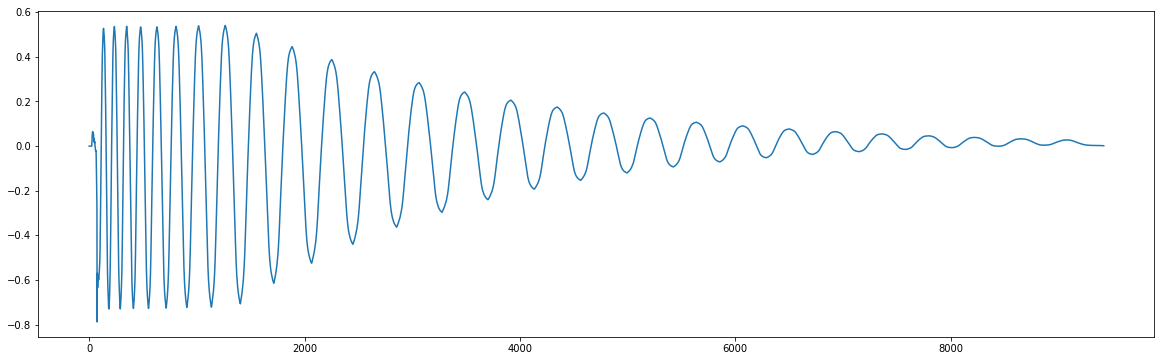

In [3]:
y, sr = librosa.load("audios/909a_22k.wav")
plot(y)
print(sr)

In [4]:
Audio(data=y[:2000],rate=sr)

16
54
157
260
377
512
669
854
1072
1330
1631
1973
2350
2752
3171
3598
4030
4462
4895
5329
5763
6198
6634
7071
7509
7951
8415
max length:  464
min length:  16


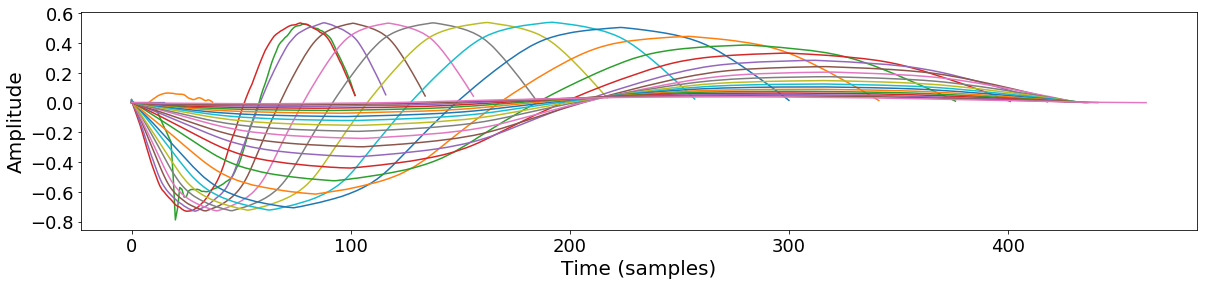

In [5]:
#divide out windows
patterns = []
figsize(20,4)
    
minPatternSize = 10
lastCrossing=0
for i in range(y.shape[0]-1):
    if (i-lastCrossing) > minPatternSize and y[i] >=0 and y[i+1] < 0:
        print(i)
        segment = y[lastCrossing:i]
        patterns.append(segment)
        lastCrossing = i
#convert to numpy
patterns = np.array(patterns, dtype=np.object)
patternLengths = [x.shape[0] for x in patterns]
maxPatternLen = np.max(patternLengths)
minPatternLen = np.min(patternLengths)
print("max length: ", maxPatternLen)
print("min length: ", minPatternLen)
plt.xlabel("Time (samples)", fontsize=20)
plt.ylabel("Amplitude", fontsize=20)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
for p in patterns:
    plot(p)
    
plt.savefig('/tmp/kickSegments.pdf', bbox_inches='tight')

In [10]:
def computeConceptor(p, net, i_pattern, alpha):
    print('Computing conceptor, alpha: ', alpha)
    Cs = np.zeros((4, 1), dtype=np.object)
    R = net['patternRs'][0,i_pattern]
    [U,s,V] = svd(R)
    S = diag(s)
    Snew = (S.dot(linalg.inv(S + pow(alpha, -2) * np.eye(p['N']))))

    C =  U.dot(Snew).dot(U.T);
    Cs[0,0] = C
    Cs[1,0] = U
    Cs[2,0] = diag(Snew)
    Cs[3,0] = diag(S)

    return locals()


def testConceptor(p, cNet, recallTestLength):
    trials = 1
    attens = np.zeros(trials)
    C = cNet['Cs'][0,0]
    LR = np.diag(p['LR'])
    LROneMinus = np.diag(1.0 - p['LR'])
    for i_trial in range(trials):
        x_CTestPL = np.zeros((p['N'], recallTestLength))
        z_CTestPL = np.zeros((p['N'], recallTestLength))
#         p_CTestPL = np.zeros((1, recallTestLength))
        x = 0.5 * np.random.randn(p['N'],1)
        z = x
        for n in range(recallTestLength + p['washoutLength']):
#             xOld = x
#             Wtarget = (cNet['net']['W'].dot(x))
#             z = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + cNet['net']['Wbias']))
            xOld = x
            Wtarget = (cNet['net']['W'].dot(x))
            leakTerm = LROneMinus.dot(xOld)
            newX =tanh(Wtarget + cNet['net']['Wbias'])
            newXLeaked = LR.dot(newX)
            z = leakTerm + newXLeaked
            x = C.dot(z)
            xPrev = x
            if (n > p['washoutLength']):
                x_CTestPL[:,n-p['washoutLength']] = x.T
                z_CTestPL[:,n-p['washoutLength']] = z.T
#                 p_CTestPL[:,n-p['washoutLength']] = cNet['net']['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))

#         attenuation = np.mean(pow(np.sum(z_CTestPL[:,:] - x_CTestPL[:,:], axis=1),2)) / np.mean(pow(np.sum(z_CTestPL[:,:], axis=1),2))
        attenuation = np.mean(pow(np.linalg.norm(z_CTestPL[:,:] - x_CTestPL[:,:], axis=1),2)) / np.mean(pow(np.linalg.norm(z_CTestPL[:,:], axis=1),2))
        attens[i_trial] = attenuation
        
    return np.mean(attens)

# nTrials = 200
# trialResults= np.zeros(nTrials)
# for i in range(nTrials):
#     cnet = computeConceptor(params, loadedNets[bestNetwork], 0, (i + 1))
#     atten = testConceptor(params, cnet, windowSize*10, 0)
#     trialResults[i] = atten
#     print(atten)
    
# plot(trialResults)

In [11]:
#create a random reservoir and load it with patterns using Jaeger's method

def makeLoadedNetwork_v2(p):
    Netconnectivity = 1
    if p['N'] > 20:
        Netconnectivity = 10.0/p['N'];
    WstarRaw = generateInternalWeights(p['N'], Netconnectivity)
    WinRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)
    WbiasRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)

    #Scale raw weights     
    Wstar = p['NetSR'] * WstarRaw;
    Win = p['NetinpScaling'] * WinRaw;
    Wbias = p['BiasScaling'] * WbiasRaw;  
    I = np.eye(p['N'])
    xCollector = np.zeros((p['N'], p['learnLength']))
    pCollector = np.zeros((1, p['learnLength']))
    x = np.zeros((p['N'],1))
    
    allTrainxArgs = np.zeros((p['N'] + 1, 0));
    allTrainOldxArgs = np.zeros((p['N'], 0));
    allTrainWtargets = np.zeros((p['N'], 0));
    allTrainOuts = np.zeros((1, 0));
    patternRs =  np.zeros((1, p['patts'].shape[0]), dtype=np.object)
    print('Loading patterns: ', end='')
    LR = np.diag(p['LR'])
    LROneMinus = np.diag(1.0 - p['LR'])
#     print(LR)
#     print(LROneMinus)
    for i_pattern in range(p['patts'].shape[0]):
        print(i_pattern, " ", end='')
        patt = p['patts'][i_pattern]
        xCollector = np.zeros((p['N'] + 1, p['learnLength']));
        xOldCollector = np.zeros((p['N'], p['learnLength']));
        WTargetCollector = np.zeros((p['N'], p['learnLength']));
        pCollector = np.zeros((1, p['learnLength']));
        x = np.zeros((p['N'], 1));

        for n in range(p['washoutLength'] + p['learnLength']):
            u = patt.take(n, mode='wrap')
            xOld = x
            Wtarget = (Wstar.dot(x)) + (Win.dot(u))
            leakTerm = LROneMinus.dot(xOld)
            newX =tanh(Wtarget + Wbias)
            newXLeaked = LR.dot(newX)
            x = leakTerm + newXLeaked

#             x = ((1.0-LR) * xOld) + (LR * tanh(Wtarget +Wbias))
#             x = tanh(Wtarget +Wbias)
            
            
            if n >= p['washoutLength']:
                xCollector[:, n - p['washoutLength']] = np.concatenate((x[:,0], np.array([1])))
                xOldCollector[:, n - p['washoutLength']] = xOld[:,0]
                WTargetCollector[:, n - p['washoutLength']] = Wtarget[:,0]
                pCollector[0, n - p['washoutLength']] = u
                
            uOld = u
        
        R = xCollector[0:-1].dot(xCollector[0:-1].T) / p['learnLength']
        patternRs[0,i_pattern] = R
        allTrainxArgs = np.concatenate((allTrainxArgs, xCollector), axis=1)
        allTrainOldxArgs = np.concatenate((allTrainOldxArgs, xOldCollector), axis=1)
        allTrainOuts = np.concatenate((allTrainOuts, pCollector), axis=1)
        allTrainWtargets = np.concatenate((allTrainWtargets, WTargetCollector), axis=1)


    Wout = (linalg.inv(allTrainxArgs.dot(allTrainxArgs.conj().T) +
                      (p['TychonovAlphaReadout'] * np.eye(p['N'] + 1))).dot(allTrainxArgs).dot(allTrainOuts.conj().T)).conj().T

    outsRecovered = Wout.dot(allTrainxArgs);
    NRMSE_readout = mean(nrmse(outsRecovered, allTrainOuts))
    absSize_readout = mean(mean(abs(Wout), axis=0))
    print("\nNRMSE readout: ", NRMSE_readout, " :: ", end='')
    print("absSize readout: ", absSize_readout)
    
    W = (linalg.inv(allTrainOldxArgs.dot(allTrainOldxArgs.conj().T) +
                      (p['TychonovAlpha'] * np.eye(p['N']))).dot(allTrainOldxArgs).dot(allTrainWtargets.conj().T)).conj().T
    NRMSE_W = mean(nrmse(W.dot(allTrainOldxArgs), allTrainWtargets))
    absSize_W = mean(mean(abs(W), axis=0))
    print("NRMSE W: ", NRMSE_W, " :: ", end='')
    print("absSize W: ", absSize_W)

    return locals()

    





N=900
LRs = np.ones(N) * 0.25
params = {'N':N, 'NetSR':1.5, 'NetinpScaling':1,'BiasScaling':0.5,'TychonovAlpha':0.0001,
         'washoutLength':maxPatternLen * 2, 'learnLength':maxPatternLen * 2, 'TychonovAlphaReadout':0.0001,
          'LR': LRs,
          'patts':patterns[np.arange(patterns.shape[0])]
         }


sampleSize = 10
loadedNets = np.zeros(sampleSize, dtype=np.object)
for i_net, net in enumerate(loadedNets):
    print(i_net)
    loadedNets[i_net] = makeLoadedNetwork_v2(params)
nrmses = [x['NRMSE_W'] for x in loadedNets]
bestNetwork = np.argmin(nrmses)
print("NRMSEs: best: ", loadedNets[bestNetwork]['NRMSE_W'], ", loadedNets[bestNetwork]['NRMSE_readout']", "avg: ", np.mean(nrmses) )


import scipy
def fitnessf(aperture, *args):
    print('Pattern: ', args[0])
    cnet = computeConceptor(params, loadedNets[bestNetwork], args[0], aperture)
    atten = testConceptor(params, cnet, maxPatternLen * 2)
    return atten

apertures = [scipy.optimize.fminbound(fitnessf, 0,1000,  disp=3, xtol=1, args = (x,)) 
             for x in np.arange(params['patts'].shape[0])]

#store conceptors with calculated apertures
patternCs = np.zeros(len(apertures), dtype=np.object)
for i_patt in range(patternCs.size):
    patternCs[i_patt] = computeConceptor(params, loadedNets[bestNetwork], i_patt, apertures[i_patt])


0
Loading patterns: 0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  
NRMSE readout:  0.0013465845215085595  :: absSize readout:  0.17903576788698009
NRMSE W:  0.0011183648412454842  :: absSize W:  0.2274165676318515
1
Loading patterns: 0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  
NRMSE readout:  0.0018256352954583352  :: absSize readout:  0.1917886449123243
NRMSE W:  0.0012856974776674895  :: absSize W:  0.2595556578859362
2
Loading patterns: 0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  
NRMSE readout:  0.0020111511473942254  :: absSize readout:  0.14983574886548828
NRMSE W:  0.001362244496282636  :: absSize W:  0.18921301690846032
3
Loading patterns: 0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  
NRMSE readout:  0.005437490242508833  :: absSize readout:  0.07860513952223445
NRMSE

   12        995.492  7.01965e-09        golden
Pattern:  3
Computing conceptor, alpha:  997.2141413580357
   13        997.214  7.01176e-09        golden
Pattern:  3
Computing conceptor, alpha:  998.2782446714134
   14        998.278   7.0069e-09        golden
Pattern:  3
Computing conceptor, alpha:  998.9358966866222
   15        998.936  7.00392e-09        golden
Pattern:  3
Computing conceptor, alpha:  999.3423479847911
   16        999.342  7.00208e-09        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  4
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  2.79653e-08        initial
Pattern:  4
Computing conceptor, alpha:  618.0339887498948
    2        618.034  1.34922e-08        golden
Pattern:  4
Computing conceptor, alpha:  763.9320225002102
    3        763.932  9.85879e-09        golden
Pattern:  4
Computing conceptor, alph

    5        792.443  1.52487e-08        parabolic
Pattern:  8
Computing conceptor, alpha:  871.7227724507362
    6        871.723  1.42538e-08        golden
Pattern:  8
Computing conceptor, alpha:  920.7203133919506
    7         920.72   1.4018e-08        golden
Pattern:  8
Computing conceptor, alpha:  936.13930659745
    8        936.139  1.37966e-08        parabolic
Pattern:  8
Computing conceptor, alpha:  960.5319209320879
    9        960.532  1.38021e-08        golden
Pattern:  8
Computing conceptor, alpha:  948.026400553517
   10        948.026  1.37214e-08        parabolic
Pattern:  8
Computing conceptor, alpha:  948.3597479483542
   11         948.36  1.38818e-08        parabolic
Pattern:  8
Computing conceptor, alpha:  947.6930531586797
   12        947.693   1.3714e-08        parabolic
Pattern:  8
Computing conceptor, alpha:  943.2799146696922
   13         943.28  1.38571e-08        golden
Pattern:  8
Computing conceptor, alpha:  947.3597057687869
   14         947.36   1.

    2        618.034  2.28918e-08        golden
Pattern:  13
Computing conceptor, alpha:  763.9320225002102
    3        763.932  2.36959e-08        golden
Pattern:  13
Computing conceptor, alpha:  626.1904721073682
    4         626.19  2.09636e-08        parabolic
Pattern:  13
Computing conceptor, alpha:  689.413935933108
    5        689.414  2.40467e-08        parabolic
Pattern:  13
Computing conceptor, alpha:  650.3396864023014
    6         650.34  2.13229e-08        golden
Pattern:  13
Computing conceptor, alpha:  637.3085280110085
    7        637.309  2.27417e-08        parabolic
Pattern:  13
Computing conceptor, alpha:  630.4371915737374
    8        630.437  2.10427e-08        golden
Pattern:  13
Computing conceptor, alpha:  623.0749726934862
    9        623.075  2.09443e-08        golden
Pattern:  13
Computing conceptor, alpha:  622.7416301184575
   10        622.742  2.27383e-08        parabolic
Pattern:  13
Computing conceptor, alpha:  623.4083152685149
   11        623.

    5        666.303   2.4588e-08        parabolic
Pattern:  18
Computing conceptor, alpha:  636.4710422790479
    6        636.471  2.88078e-08        golden
Pattern:  18
Computing conceptor, alpha:  601.2039795932845
    7        601.204  2.51349e-08        golden
Pattern:  18
Computing conceptor, alpha:  625.0763165456301
    8        625.076   2.4437e-08        golden
Pattern:  18
Computing conceptor, alpha:  629.4287144833127
    9        629.429   2.4363e-08        golden
Pattern:  18
Computing conceptor, alpha:  632.1186443413654
   10        632.119  2.45146e-08        golden
Pattern:  18
Computing conceptor, alpha:  627.7662464036829
   11        627.766  2.45523e-08        golden
Pattern:  18
Computing conceptor, alpha:  630.4561762617357
   12        630.456  2.49529e-08        golden
Pattern:  18
Computing conceptor, alpha:  628.7937081821059
   13        628.794  2.43963e-08        golden
Pattern:  18
Computing conceptor, alpha:  629.8211699605288
   14        629.821  2.5

    3        763.932  1.16273e-08        golden
Pattern:  23
Computing conceptor, alpha:  620.6340484615057
    4        620.634  1.16421e-08        parabolic
Pattern:  23
Computing conceptor, alpha:  527.8640450004206
    5        527.864  1.14477e-08        golden
Pattern:  23
Computing conceptor, alpha:  583.5921350012618
    6        583.592  1.16869e-08        golden
Pattern:  23
Computing conceptor, alpha:  604.8783712534699
    7        604.878  1.10573e-08        golden
Pattern:  23
Computing conceptor, alpha:  591.8504879362166
    8         591.85  1.19238e-08        parabolic
Pattern:  23
Computing conceptor, alpha:  609.9033699941115
    9        609.903  1.15928e-08        golden
Pattern:  23
Computing conceptor, alpha:  599.9021626277469
   10        599.902  1.11746e-08        golden
Pattern:  23
Computing conceptor, alpha:  606.7977499789696
   11        606.798  1.11304e-08        golden
Pattern:  23
Computing conceptor, alpha:  602.9776286935542
   12        602.978  

1.4247754302334714
0.5253896328224223
0.07402268048880499
0.007743222578628563
0.004045403157880048
0.00413036103317396
0.0018048327705551513
0.007582935285726055
0.0051697143063762115
0.0033354317259062503
0.003202267492047174
0.006927912164328027
0.01026158523659354
0.013268316282753578
0.005917982036110747
0.015741339997935033
0.009917374926828171
0.00952455099240199
0.01743640676507107
0.012446051714050698
0.012587046374732886
0.02300615456601253
0.02017096564693939
0.021620955121663215
0.06416886115344099
0.0668609888853438
0.08014490990640868


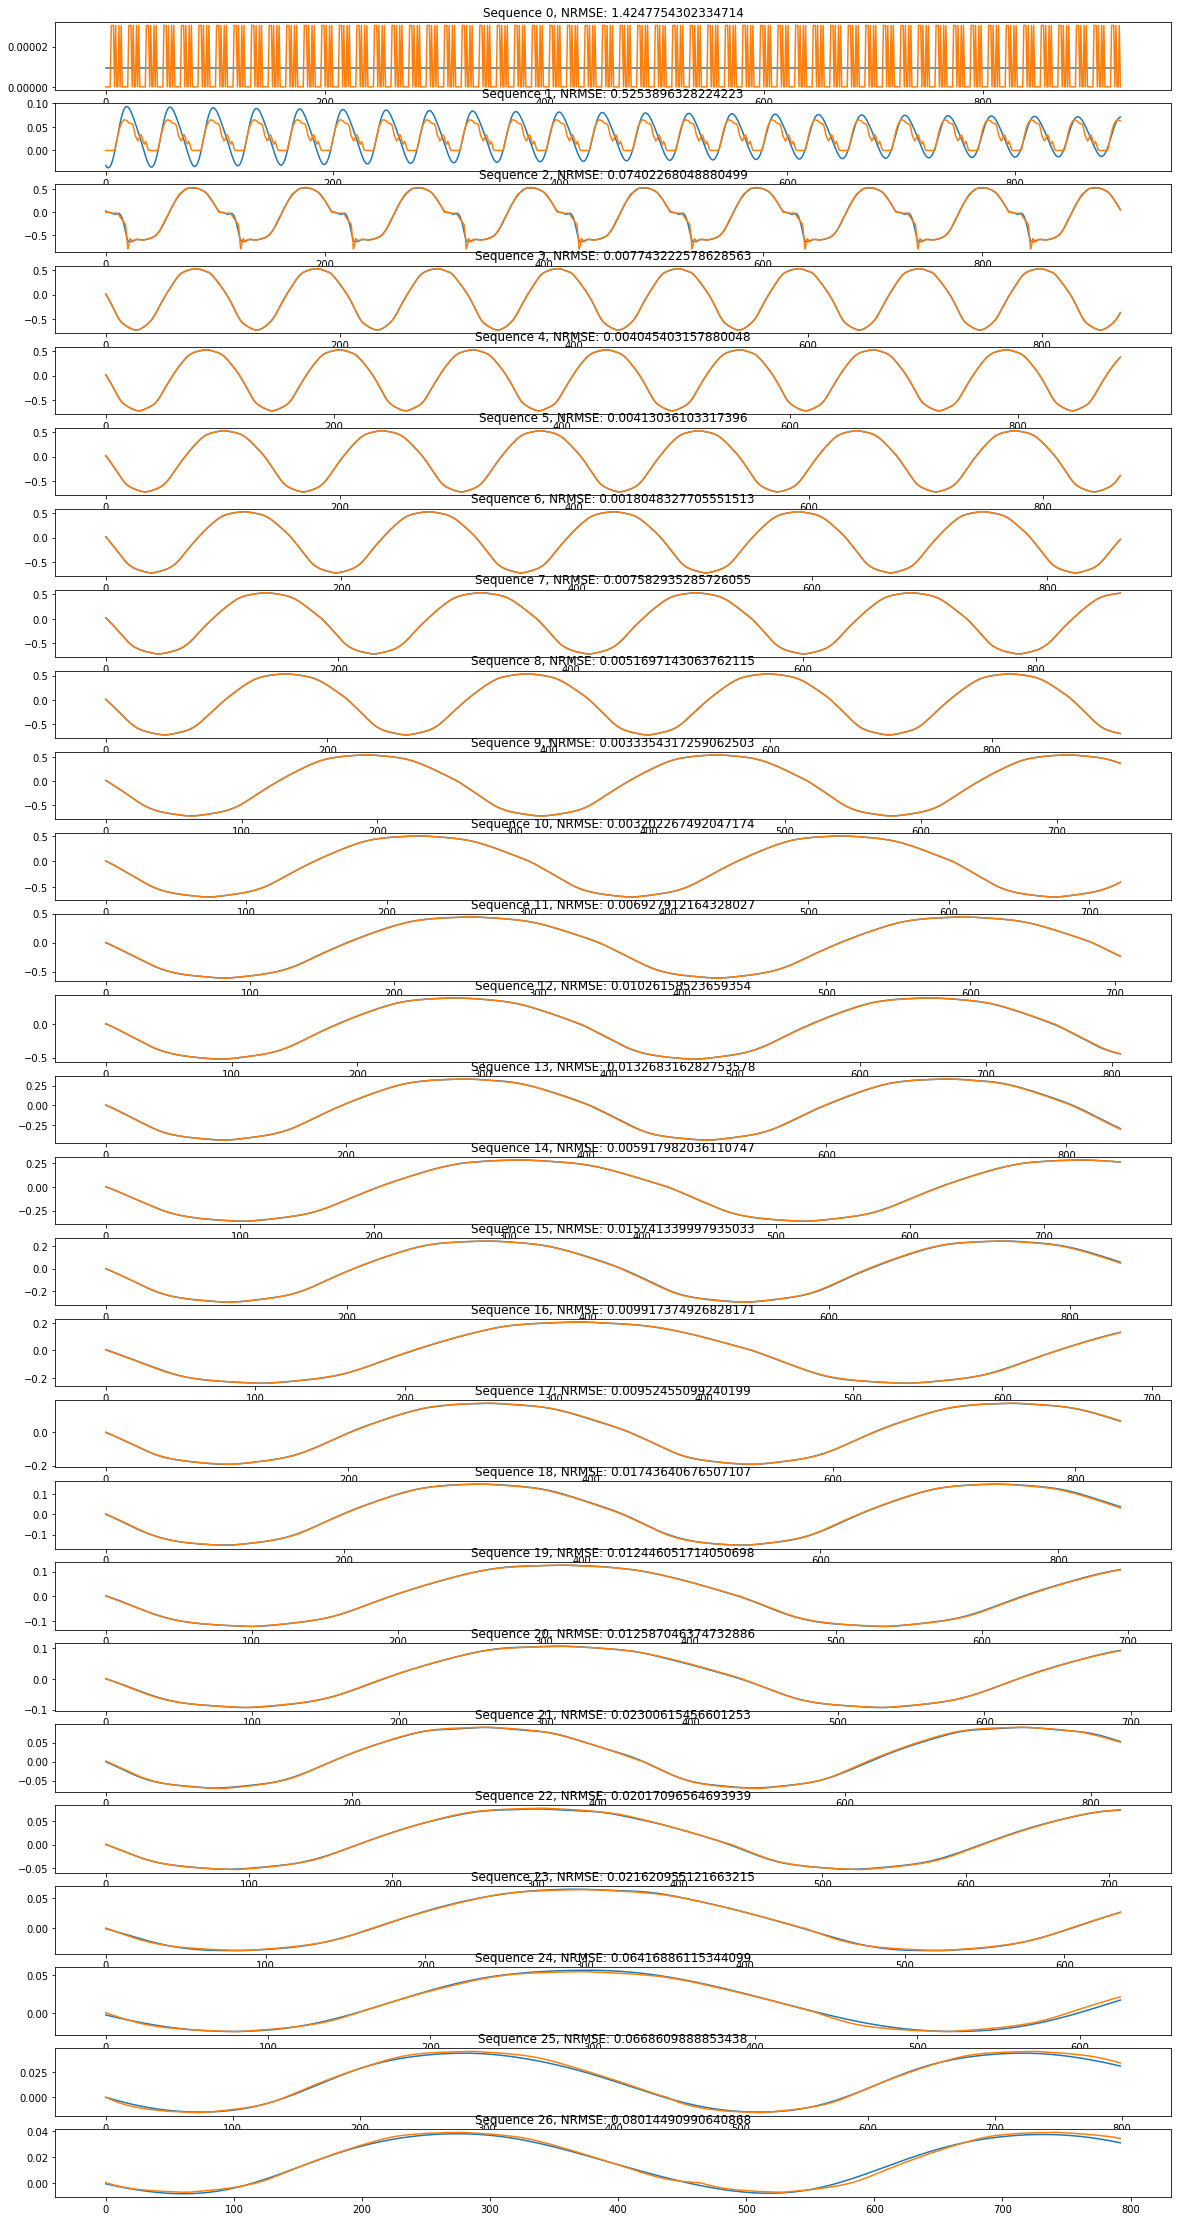

In [12]:
def plotConceptorPattern(p, cNet, recallTestLength, i_pattern):
    x_CTestPL = np.zeros((p['N'], recallTestLength, p['patts'].shape[0]))
    z_CTestPL = np.zeros((p['N'], recallTestLength, p['patts'].shape[0]))
    p_CTestPL = np.zeros((1, recallTestLength, p['patts'].shape[0]))
    C = cNet['Cs'][0,0]
    x = 0.5 * np.random.randn(p['N'],1)
    z = x
    LR = np.diag(p['LR'])
    LROneMinus = np.diag(1.0 - p['LR'])
    for n in range(recallTestLength + p['washoutLength']):
        xOld = x
        Wtarget = (cNet['net']['W'].dot(x))
        z = (LROneMinus.dot(xOld)) + (LR.dot(tanh(Wtarget + cNet['net']['Wbias'])))
        x = C.dot(z)
        xPrev = x
        if (n > p['washoutLength']):
            x_CTestPL[:,n-p['washoutLength'],i_pattern] = x.T
            z_CTestPL[:,n-p['washoutLength'],i_pattern] = z.T
            p_CTestPL[:,n-p['washoutLength'],i_pattern] = cNet['net']['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))
    
    
    outputPattern = p_CTestPL[:,:,i_pattern][0]
    targetPattern = np.array([p['patts'][i_pattern].take(x, mode='wrap') for x in arange(recallTestLength)])
    templateScan = np.correlate(outputPattern[:p['patts'][i_pattern].size*2],p['patts'][i_pattern])
    matchPoint = np.argmax(templateScan)
    if (matchPoint > 0):
        outputPattern = outputPattern[matchPoint:]
        targetPattern = targetPattern[:-matchPoint]
    score = nrmse(outputPattern, targetPattern) 
    print(score)
    plot(outputPattern)
    plot(targetPattern)
    return score
    
figsize(20,40)
scores = np.zeros(len(apertures))
for i_patt in range(len(apertures)):
    ax = subplot(len(apertures), 1, i_patt+1)
    scores[i_patt] = plotConceptorPattern(params, patternCs[i_patt], maxPatternLen * 2, i_patt)
    ax.set_title("Sequence " + str(i_patt) + ", NRMSE: " + str(scores[i_patt]))    

plt.savefig("tmp/909_tests.pdf")

0.09078530791354099
[1.42477543 0.52538963 0.07402268 0.00774322 0.0040454  0.00413036
 0.00180483 0.00758294 0.00516971 0.00333543 0.00320227 0.00692791
 0.01026159 0.01326832 0.00591798 0.01574134 0.00991737 0.00952455
 0.01743641 0.01244605 0.01258705 0.02300615 0.02017097 0.02162096
 0.06416886 0.06686099 0.08014491]
[0.00180483 0.00320227 0.00333543 0.0040454  0.00413036 0.00516971
 0.00591798 0.00692791 0.00758294 0.00774322 0.00952455 0.00991737
 0.01026159 0.01244605 0.01258705 0.01326832 0.01574134 0.01743641
 0.02017097 0.02162096 0.02300615 0.06416886 0.06686099 0.07402268
 0.08014491 0.52538963 1.42477543]


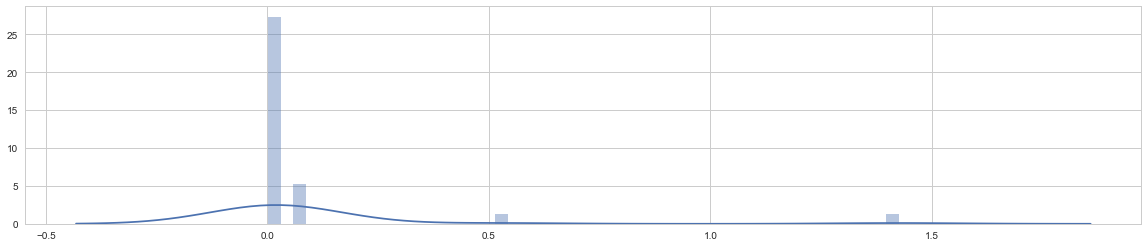

In [13]:
import seaborn as sns
sns.set(style="whitegrid")
print(np.mean(scores))
print(scores)
figsize(20,4)
# plot(sort(scores))
print(sort(scores))
# print(median(scores))
sns.distplot(scores)
plt.savefig("tmp/909scoresDistrib.pdf")

In [14]:

def render(p, lrMod=1.0, speed=1.0, xFade=0.05):
    audio = np.zeros(0)
    x = 0.5 * np.random.randn(p['N'],1)
    cNet = patternCs[0]
    C = cNet['Cs'][0,0]
    
    LR = np.diag(p['LR'])
    LR = LR * lrMod
    LROneMinus = np.diag(1.0 - p['LR'])
    
    #run to washout
    for n in range(p['washoutLength']):
        xOld = x
        Wtarget = (cNet['net']['W'].dot(x))
        z = (LROneMinus.dot(xOld)) + (LR.dot(tanh(Wtarget + cNet['net']['Wbias'])))
        x = C.dot(z)


    for i_patt in range(patterns.shape[0]):
#         print('=')
        xFadeTime=int(patterns[i_patt].shape[0] * xFade)
        for n in range(int(patterns[i_patt].shape[0] * speed)):
            cNet = patternCs[i_patt]
            v=int(patterns[i_patt].shape[0] * speed)
            stepL = min(v - n - 1, xFadeTime)
            stepU = min(n, xFadeTime)
            m1 = 1.0
            if(n > v-xFadeTime-1 and i_patt < patterns.shape[0]-1):
                m1 = (stepL + stepU) / (2*xFadeTime)
                nextC = patternCs[i_patt+1]
                C = (m1 * cNet['Cs'][0,0]) + ((1.0-m1) * nextC['Cs'][0,0])
#                     print(m1)
            else:
                if (n < xFadeTime and i_patt > 0):
                    m1 = 0.5 - (n / (2*xFadeTime))
                    prevC = patternCs[i_patt-1]
                    C = (m1 * prevC['Cs'][0,0]) + ((1.0-m1) * cNet['Cs'][0,0])
#                         print("-",m1)
                else:
                    C = cNet['Cs'][0,0]
            
            xOld = x
            Wtarget = (cNet['net']['W'].dot(x))
            z = (LROneMinus.dot(xOld)) + (LR.dot(tanh(Wtarget + cNet['net']['Wbias'])))
            x = C.dot(z)

            newSample = cNet['net']['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))
            audio = np.concatenate((audio, newSample))
    return audio

audio = render(params)
print("done")

done


/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/resampy/core.py:90: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(x.dtype, np.float):


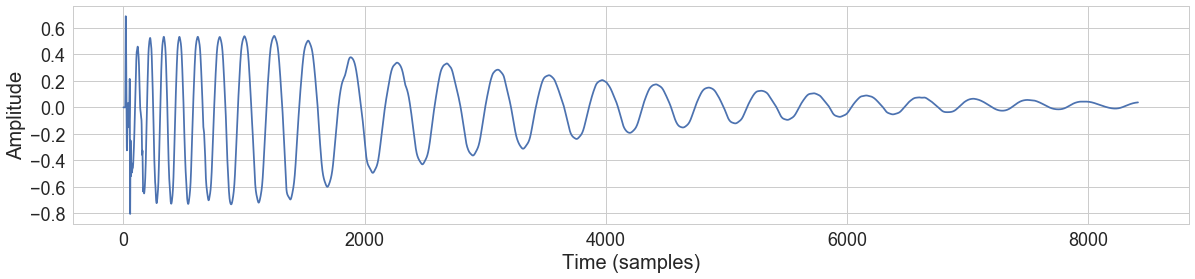

In [16]:
figsize(20,4)
plot(audio)
plt.xlabel("Time (samples)", fontsize=20)
plt.ylabel("Amplitude", fontsize=20)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
# plot(y[:audio.size])
plt.savefig('tmp/909recon.pdf', bbox_inches='tight')
librosa.output.write_wav("tmp/909recon.wav", librosa.resample(audio, sr, 44100), 44100)
Audio(data=audio,rate=sr)


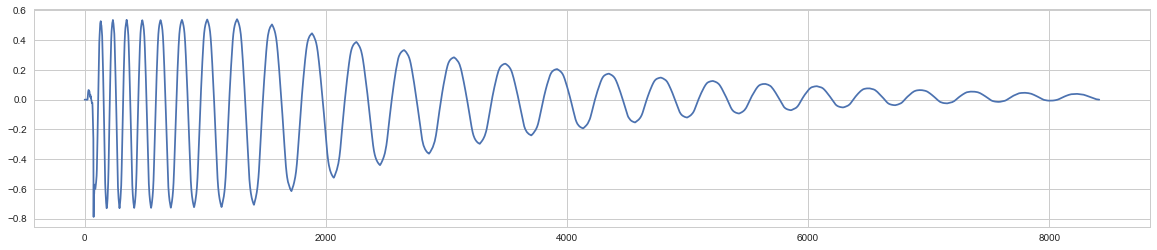

In [17]:
plot(y[:audio.size])
Audio(data=y[:audio.size],rate=sr)


0.5512370392651235


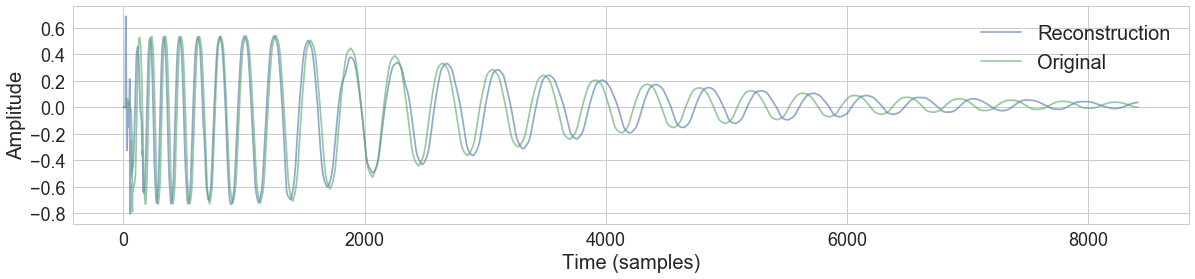

In [27]:
figsize(20,4)
plot(audio, alpha=0.6,label='Reconstruction')
plot(y[:audio.size], alpha=0.6, label='Original')
plt.xlabel("Time (samples)", fontsize=20)
plt.ylabel("Amplitude", fontsize=20)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
plt.legend(fontsize=20)
plt.savefig("tmp/909reconCompare.pdf", bbox_inches='tight')
print(nrmse(audio, y[:audio.size]))


/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


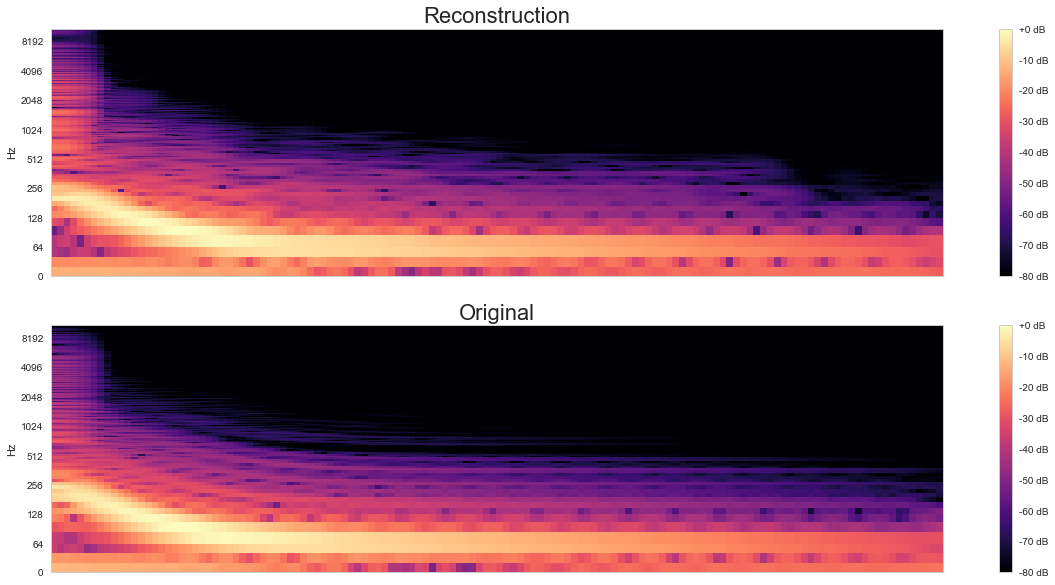

In [22]:
figsize(20,10)
import librosa.display
subplot(2,1,1)
CQT = librosa.amplitude_to_db(librosa.stft(audio, n_fft=1024, hop_length=64), ref=np.max)
ax = librosa.display.specshow(CQT, y_axis='log', sr=22050)
plt.colorbar(format='%+2.0f dB')
ax.set_title('Reconstruction', fontsize=22)
subplot(2,1,2)
CQT = librosa.amplitude_to_db(librosa.stft(y[:audio.shape[0]], n_fft=1024, hop_length=64), ref=np.max)
ax = librosa.display.specshow(CQT, y_axis='log', sr=22050)
plt.colorbar(format='%+2.0f dB')
ax.set_title('Original', fontsize=22)
plt.savefig("tmp/expt2Spectra.pdf")

In [20]:
import dill as pickle
model = {"net":loadedNets[bestNetwork], "Cs":patternCs, "apertures":apertures}
with open(r"models/expt2KickModel.pickled", "wb") as output_file:    
    pickle.dump(model, output_file, protocol=0)

# with open(r"models/expt2KickModel.pickled", "rb") as in_file:    
#     model = pickle.load(in_file)

In [16]:
patternCs = model['Cs']
bestNetwork=0
loadedNets = np.zeros(1, dtype=np.object)
loadedNets[bestNetwork] = model['net']
apertures = model['apertures']
params = model['net']['p']
patterns = model['net']['p']['patts']

/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/resampy/core.py:90: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(x.dtype, np.float):


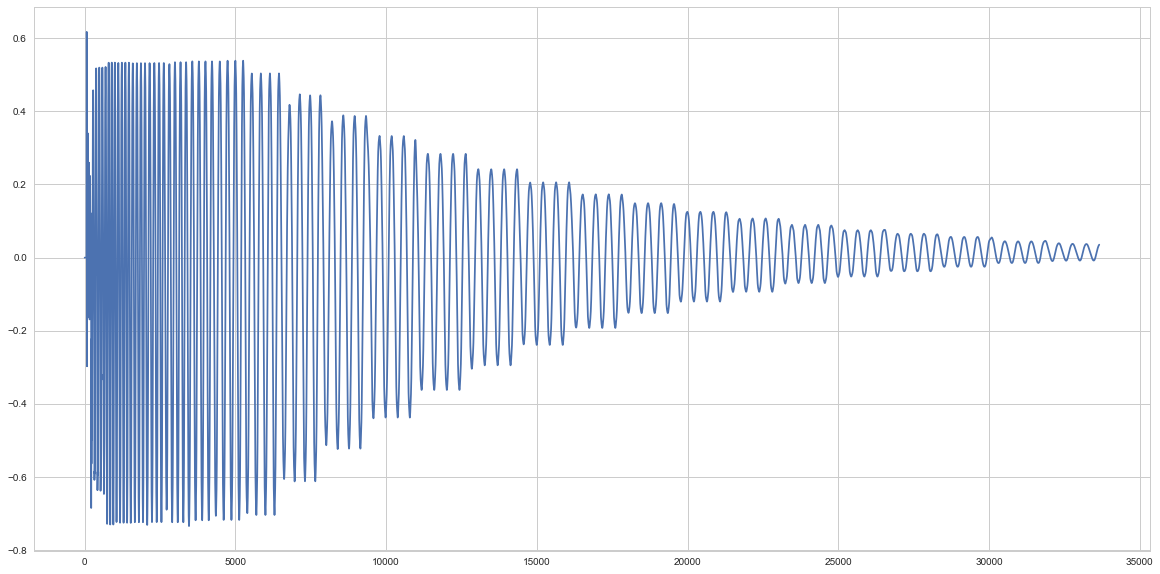

In [23]:
audiots = render(loadedNets[bestNetwork]['p'], 1.0, 4.0,0.1)
plot(audiots)
# plot(y[:audio.size])
plt.savefig('tmp/909Stretch4xrecon.pdf')
librosa.output.write_wav("tmp/909Stretch4xrecon.wav", librosa.resample(audiots, sr, 44100), 44100)
Audio(data=audiots,rate=sr)

/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


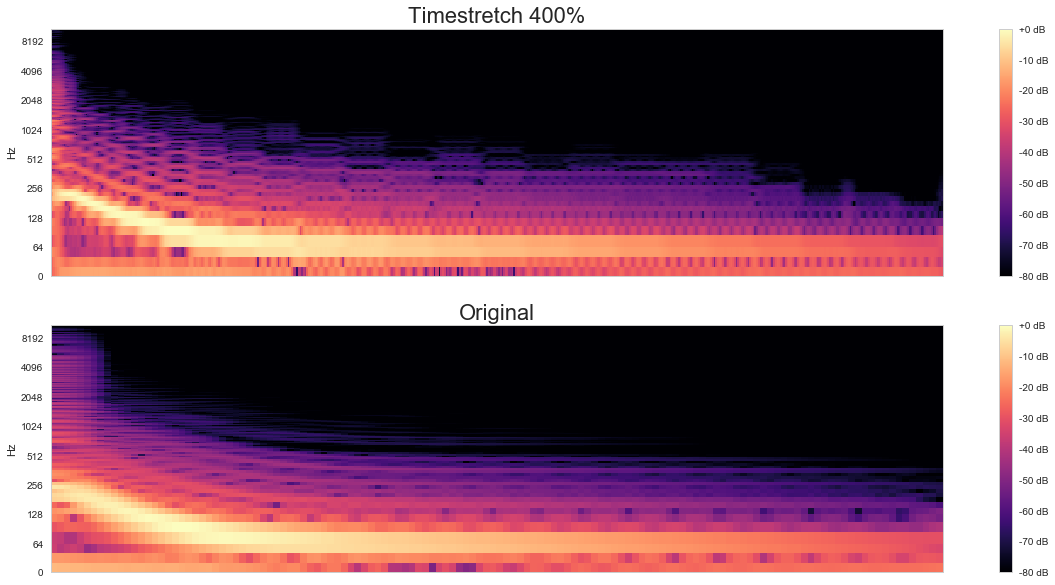

In [24]:
figsize(20,10)
import librosa.display
subplot(2,1,1)
CQT = librosa.amplitude_to_db(librosa.stft(audiots, n_fft=1024, hop_length=64), ref=np.max)
ax = librosa.display.specshow(CQT, y_axis='log', sr=22050)
plt.colorbar(format='%+2.0f dB')
ax.set_title('Timestretch 400%', fontsize=22)
subplot(2,1,2)
CQT = librosa.amplitude_to_db(librosa.stft(y[:audio.shape[0]], n_fft=1024, hop_length=64), ref=np.max)
ax = librosa.display.specshow(CQT, y_axis='log', sr=22050)
plt.colorbar(format='%+2.0f dB')
ax.set_title('Original', fontsize=22)
plt.savefig("tmp/expt2TSSpectra.pdf")

0.5
1
1.5
2
2.5
3
3.5
4
4.5
5
5.5
6
6.5
7
7.5
8


/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/resampy/core.py:90: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(x.dtype, np.float):


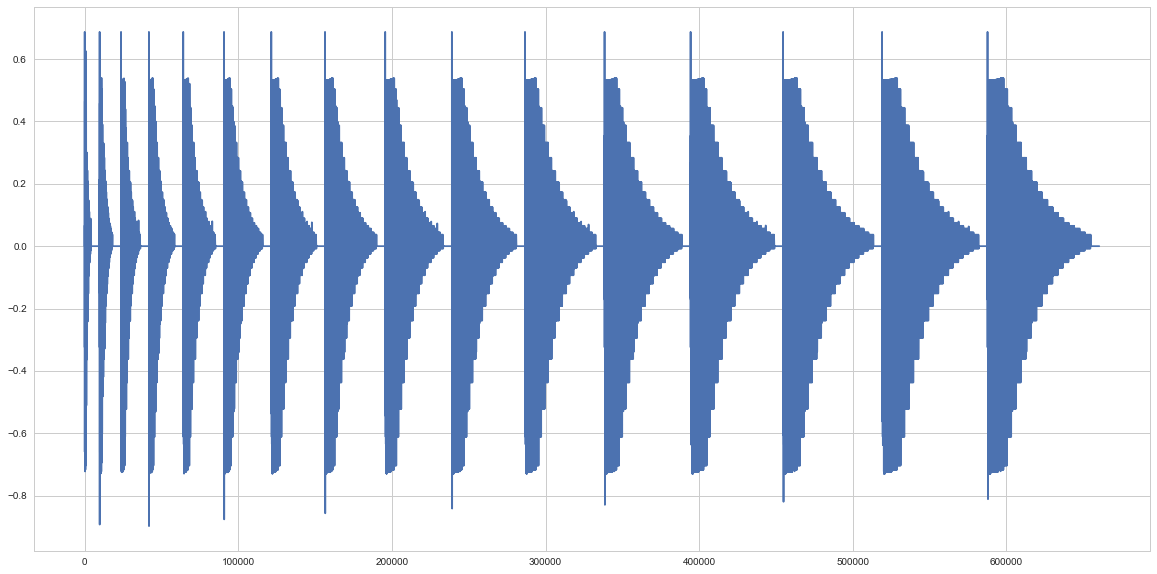

In [25]:
wave = np.zeros(0)
for sp in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8]:
    print(sp)
    audiots = render(loadedNets[bestNetwork]['p'], 1.0, sp,0.03)
    wave = np.concatenate((wave, audiots, np.zeros(int(22050/4))))

plot(wave)
    # plot(y[:audio.size])
#     plt.savefig('tmp/909Stretch4xrecon.pdf')
librosa.output.write_wav("tmp/909StretchMultiple.wav", librosa.resample(wave, sr, 44100), 44100)
Audio(data=wave,rate=sr)